### AutoML/Hyperparameter Tuning

Given the nature of this project as wholly unsupervised, clustering and anomaly detection are the only real models that can be run on our data. Accuracy cannot be evaluated on unlabeled data, but computational time and interpretability can be.<br> <br>

To that end, this notebook using PyCaret optimally cluster the data.

#### Set up your environment
Use the mlgeo enviroment from class

In [79]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os
import time

!pip install pycaret
import pycaret
from pycaret.regression import tune_model

#### Data Note

This analysis was originally attempted with spectrogram data, as is done in Zali et al., but to poor results here using simpler machine learning methods. For the purpose of exploring AutoML, statistics on the data were computed and used in place of the raw spectra

In [80]:
#read in spectras file to dataframe
filepath = os.getcwd() + '/data/ai_ready/'
# filename = 'spectra.npy'
# df = pd.DataFrame(np.load(filepath+filename))
filename = 'statistics.csv'
df = pd.read_csv(filepath+filename)
df.head()

,mean,max,min,median,range,std,spec_mean,spec_max,spec_min,spec_median,spec_range,spec_std
0,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.004337,0.153382,7.070107e-07,0.000710,0.153382,0.010231
1,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003954,0.150999,1.275567e-06,0.000715,0.150998,0.008960
2,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003816,0.177869,2.608655e-06,0.000687,0.177866,0.008829
3,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.004417,0.323616,6.022107e-07,0.000681,0.323615,0.012174
4,0.004287,0.890882,-1.0,0.004514,1.890882,0.097879,0.003979,0.139368,5.308308e-07,0.000616,0.139368,0.009023


In [81]:
# import pycaret clustering and init setup
from pycaret.clustering import *
s = setup(df, normalize=True, session_id = 120)

,Description,Value
0,Session id,120
1,Original data shape,"(2400, 12)"
2,Transformed data shape,"(2400, 12)"
3,Numeric features,12
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,Normalize,True
9,Normalize method,zscore


In [82]:
# import ClusteringExperiment and init the class
from pycaret.clustering import ClusteringExperiment
exp = ClusteringExperiment()

# check the type of exp
type(exp)

pycaret.clustering.oop.ClusteringExperiment

In [83]:
# init setup on exp
exp.setup(data = df, pca=True, session_id = 120)

,Description,Value
0,Session id,120
1,Original data shape,"(2400, 12)"
2,Transformed data shape,"(2400, 12)"
3,Numeric features,12
4,Preprocess,True
5,Imputation type,simple
6,Numeric imputation,mean
7,Categorical imputation,mode
8,PCA,True
9,PCA method,linear


### Create Model

Trains and evaluates a given model

In [84]:
#check all available models
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch


In [85]:
#train kmeans model
aggl = create_model('hclust')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2397,670.9322,1.5289,0,0,0


### Assign Model
Actually assign labels using a given clustering model

In [86]:
aggl_cluster = assign_model(aggl)
aggl_cluster.Cluster

0       Cluster 1
1       Cluster 1
2       Cluster 1
3       Cluster 1
4       Cluster 1
          ...    
2395    Cluster 0
2396    Cluster 0
2397    Cluster 0
2398    Cluster 0
2399    Cluster 0
Name: Cluster, Length: 2400, dtype: object

### Visualize Model

In [87]:
plot_model(aggl, plot = 'cluster')

### Plot Elbow Curve for Clustering

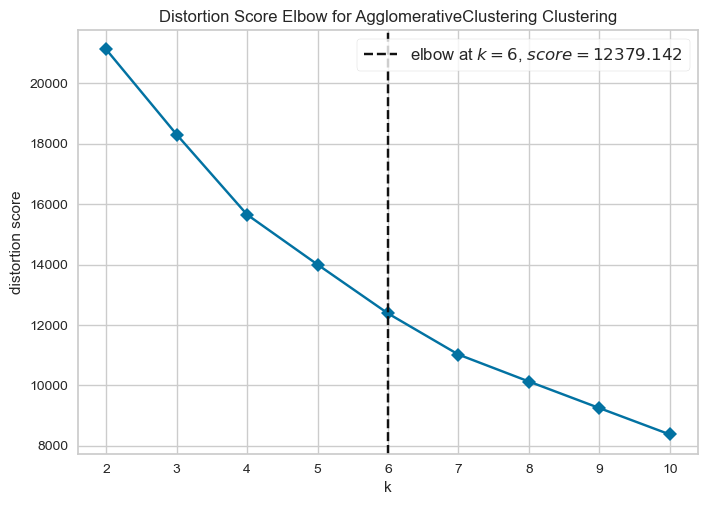

In [88]:
plot_model(aggl, plot = 'elbow')

### Plot Clustering Again with Updated Cluster Number

In [89]:
aggl = create_model('hclust', num_clusters=6)
plot_model(aggl, plot = 'cluster')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2557,635.1254,1.4013,0,0,0


### Plot Silhoutte

Only seems to work for kmeans model. This appears to be a bug with this version of pycaret, as other models have silhouette scores.

In [90]:
#plot_model(kmeans, plot = 'silhouette')

### Now Run for All Model Options and Compare Performance

In [91]:
model_list = ['kmeans', 'ap', 'meanshift', 'sc', 'hclust', 'dbscan', 'optics', 'birch']

### Brief Description of the Algorithms Tested
K-Means Clustering : Minimizes the distance of the data points relative to a given number of centroids <br><br>

Affinity Propagation : Clusters points based on a similarity function, requires a set number of clusters and eigenvectors to use. <br><br>

Mean Shift Clustering : Seeks to group data according to maximas in an underlying density function. Does not require a present cluster number. <br><br>

Spectral Clustering : Uses the eigenvectors of the data's similarity matrix to reduce the data's dimension and then k-means clustering. <br><br>

Agglomerative Clustering : Begins with each point as it's own cluster, and progressively merges clusters to maximize the distance between clusters.<br><br>

DBSCAN : Forms clusters by separating areas of low and high density, two parameters must be set to decide what is considered 'dense'. <br><br>

OPTICS : Is similar to DBSCAN, but can have a less rigid definition of density.<br><br>

BIRCH : Clusters by first performing extreme dimensionality reduction to the data, and incrementally adding complexity back in until given, threshold, branching, and cluster number parameters are met.

### Searching Hyper-Parameter Space
Because there are all clustering models, the hyperparameter space is mainly the number of clusters fed into the initial model. Many of PyCaret's models can't be plotted as elbow plots, for some reason, and the k estimate from those elbow plots can't be accessed as an attribute, so I am instead searching over a range from 3 to 9 clusters for each model and saving it's performance

In [94]:
performance_df = pd.DataFrame(columns=["Silhouette",'Calinski-Harabasz','Davies-Bouldin',
                                       'Homogeneity','Rand Index', 'Completeness'])

ks = [2,3,4,5,6,7,8,9]

#create list to store compute time
times = []

for model in model_list:
    for k in ks:
        time1 = time.time()
        create_model(model, num_clusters=k)
        time2 = time.time()
        dtime = time2 - time1
        times.append(dtime)

        performance_df.loc[len(performance_df)] = pull().to_numpy()[0]

performance_df['Model'] = np.repeat(model_list, len(ks))
performance_df['Time'] = times
performance_df['Clusters'] = np.tile(ks, len(model_list))

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3890,1164.9886,1.3069,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2553,812.6918,1.3168,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2798,776.4215,1.2559,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2912,716.2266,1.1106,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2833,701.8813,1.2809,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3168,766.8833,1.1592,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3075,735.0006,1.1243,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3074,716.4974,1.1717,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5611,166.7869,0.5558,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4948,323.9184,0.7863,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4779,230.0238,1.0160,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3821,179.7470,0.9871,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3536,163.9698,0.9478,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3554,139.8204,0.9634,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3466,127.8450,0.9326,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3071,121.7304,0.9700,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3957,871.2757,1.4440,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2176,687.0406,1.7194,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2397,670.9322,1.5289,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2467,633.0948,1.5221,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2557,635.1254,1.4013,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2682,643.7483,1.2807,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2729,630.3871,1.2319,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2822,632.2631,1.3248,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4865,419.1576,0.9190,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3752,632.9776,1.2996,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3641,516.7695,1.1068,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2929,545.5942,1.1354,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2861,490.6276,1.3260,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2699,574.4751,1.3142,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2696,514.4972,1.2762,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2464,468.2927,1.3373,0,0,0


In [118]:
performance_df.head()

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,Model,Time,Clusters
0,0.3890,1164.9886,1.3069,0.0,0.0,0.0,kmeans,0.246810,2
1,0.2553,812.6918,1.3168,0.0,0.0,0.0,kmeans,0.165502,3
2,0.2798,776.4215,1.2559,0.0,0.0,0.0,kmeans,0.142962,4
3,0.2912,716.2266,1.1106,0.0,0.0,0.0,kmeans,0.171391,5
4,0.2833,701.8813,1.2809,0.0,0.0,0.0,kmeans,0.146561,6


### Plot Homemade Elbow Plots to Determine at Which Cluster to Evaluate Performance
Need to be mindful of overfitting and not simply go with the model with the most clusters

In [127]:
def elbow(df, model):
    fig = plt.figure(figsize=(6,6))
    plot_df = df.query('Model == @model')

    # #sum all normalized quality metrics together (negative Davies-Bouldin)
    # quality = plot_df.Silhouette / plot_df.Silhouette.max() + \
    #     plot_df['Calinski-Harabasz'] / plot_df['Calinski-Harabasz'].max() - \
    #         plot_df['Davies-Bouldin'] / plot_df['Davies-Bouldin'].max()

    #sum all normalized quality metrics together (negative Davies-Bouldin)
    quality = plot_df.Silhouette / df.Silhouette.max() + \
        plot_df['Calinski-Harabasz'] / df['Calinski-Harabasz'].max() - \
            plot_df['Davies-Bouldin'] / df['Davies-Bouldin'].max()

    plt.plot(plot_df.Clusters, quality)
    plt.title(model+' Quality Score over Cluster Number')
    plt.xlabel('Clusters')
    plt.ylabel('Quality Score')
    return(fig)

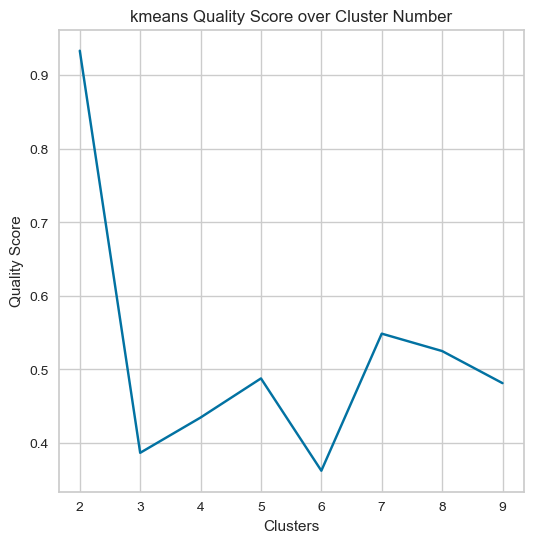

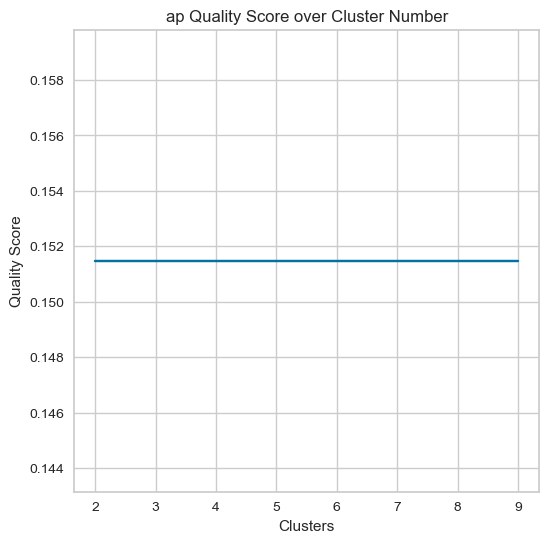

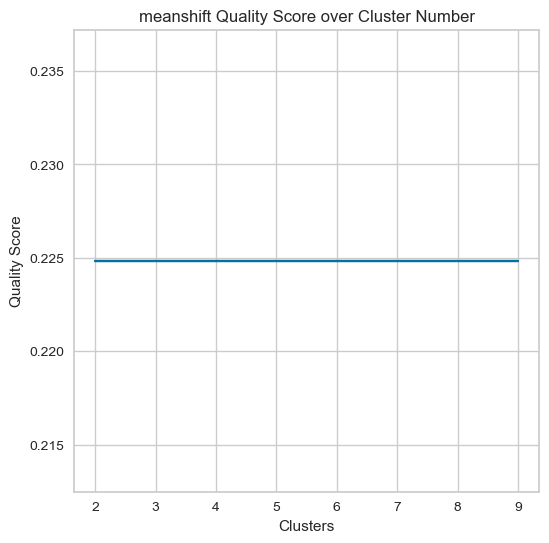

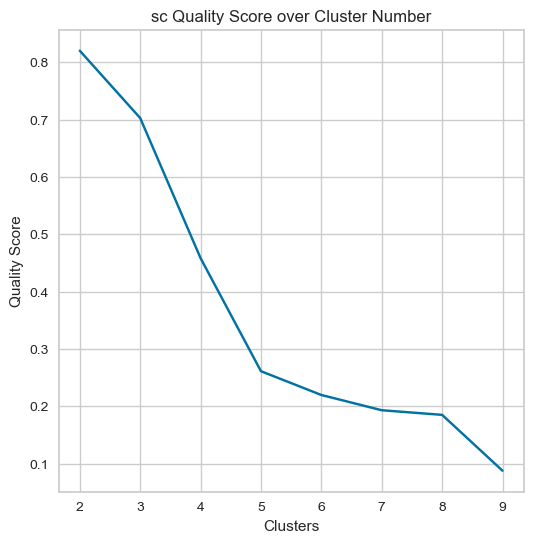

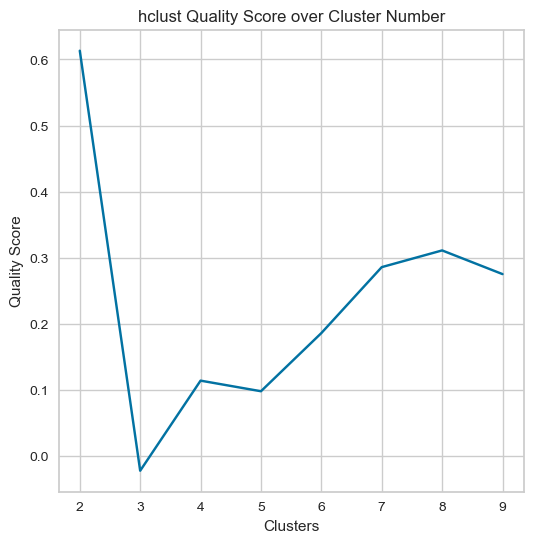

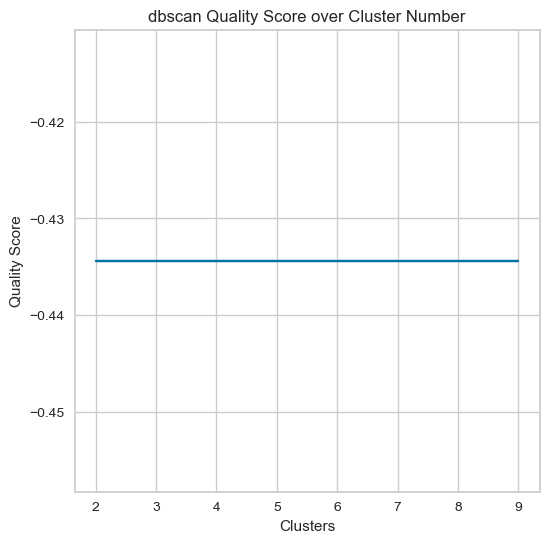

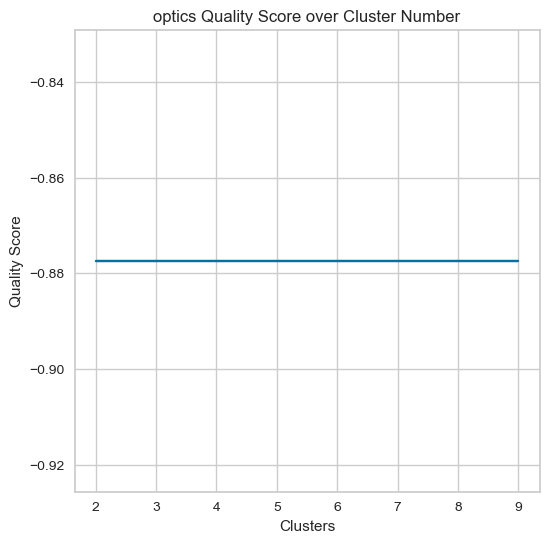

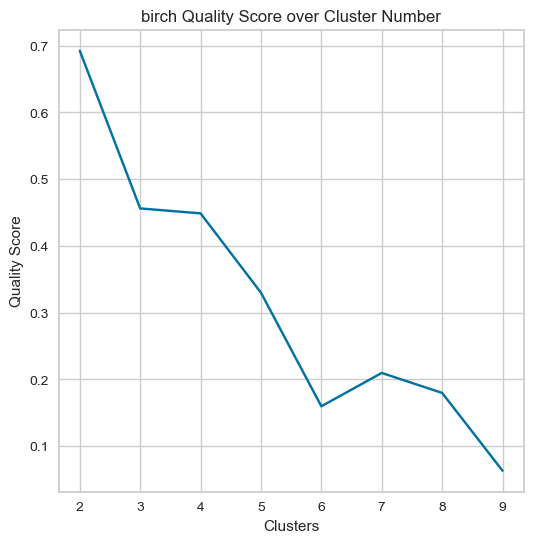

In [128]:
#'Elbow Plots' Using a score combining all of the computed performance indeces

for model in model_list:
    elbow(performance_df, model)

### Determine Ideal Cluster Numbers by Visual Inspection

Want to maximize quality metric. Zali et al. 2024 found 4 clusters related to eruptive activity, so I will limit k >= 3. For the models that do not react to changes in k, 3 will be chosen to ensure fastest running time.

In [136]:
model_list

['kmeans', 'ap', 'meanshift', 'sc', 'hclust', 'dbscan', 'optics', 'birch']

In [138]:
kvals = {'kmeans_k' : 7,
        'ap_k' : 3,
        'meanshift_k' : 3,
        'sc_k' : 3,
        'hclust_k' : 8,
        'dbscan_k' : 3,
        'optics_k' : 3,
        'birch_k' : 3}

for key in kvals.keys():
    print(key)
    print(kvals[key])

#recalculate performance df with optimal cluster numbers

performance_df = pd.DataFrame(columns=["Silhouette",'Calinski-Harabasz','Davies-Bouldin',
                                    'Homogeneity','Rand Index', 'Completeness'])

#create list to store compute time
times = []
model_list = []
ks = []

for key in kvals.keys():
    model = key.split('_')[0]
    k = kvals[key]

    model_list.append(model)
    ks.append(k)

    time1 = time.time()
    create_model(model, num_clusters=k)
    time2 = time.time()
    dtime = time2 - time1
    times.append(dtime)

    performance_df.loc[len(performance_df)] = pull().to_numpy()[0]

performance_df['Model'] = model_list
performance_df['Time'] = times
performance_df['Clusters'] = ks

kmeans_k
7
ap_k
3
meanshift_k
3
sc_k
3
hclust_k
8
dbscan_k
3
optics_k
3
birch_k
3


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3168,766.8833,1.1592,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2909,186.3532,0.9060,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4352,188.3531,1.2250,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4948,323.9184,0.7863,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.2729,630.3871,1.2319,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0877,39.1644,1.0734,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,-0.0482,13.7795,1.3812,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3752,632.9776,1.2996,0,0,0


In [140]:
#add column for 'quality value
performance_df['Quality'] = performance_df.Silhouette/np.max(performance_df.Silhouette) + \
    performance_df['Calinski-Harabasz']/np.max(performance_df['Calinski-Harabasz']) - \
        performance_df['Davies-Bouldin']/np.max(performance_df['Davies-Bouldin'])

In [141]:
#examince performance df for optimal model
performance_df

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness,Model,Time,Clusters,Quality
0,0.3168,766.8833,1.1592,0.0,0.0,0.0,kmeans,0.230966,7,0.800988
1,0.2909,186.3532,0.9060,0.0,0.0,0.0,ap,5.864957,3,0.174964
2,0.4352,188.3531,1.2250,0.0,0.0,0.0,meanshift,1.019118,3,0.238246
3,0.4948,323.9184,0.7863,0.0,0.0,0.0,sc,40.763509,3,0.853095
4,0.2729,630.3871,1.2319,0.0,0.0,0.0,hclust,0.196300,8,0.481642
5,0.0877,39.1644,1.0734,0.0,0.0,0.0,dbscan,0.195742,3,-0.548837
6,-0.0482,13.7795,1.3812,0.0,0.0,0.0,optics,38.697079,3,-1.079445
7,0.3752,632.9776,1.2996,0.0,0.0,0.0,birch,0.185792,3,0.642755


In [146]:
#plotting the two best performers, kmeans and spectral clustering
kmeans = create_model('kmeans', num_clusters=7)
print('Kmeans Clusters')
plot_model(kmeans, plot = 'cluster')

sc = create_model('sc', num_clusters=3)
print('Spectral Clusters')
plot_model(sc, plot = 'cluster');

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3168,766.8833,1.1592,0,0,0


Kmeans Clusters


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4948,323.9184,0.7863,0,0,0


Spectral Clusters


### Results

The two best performing clustering methods were kmeans and spectral clustering. Without a ground truth to truly determine whether the clusters are accurate, the model performance can only really be evaluated by using cluster indeces: Silhouette, Calinski-Harabasz, and Davies-Bouldin. Combining these three into a single 'Quality' metric, kmeans and sc models handily outperformed the other 5 included in PyCaret. <br><br>

However, despite kmeans higher quality score and much much faster computation time, the sc model makes more intuitive sense, and visually looks more compelling. Given that we are studying volcanic processes, 3 distinguishable modes seems more logical than the 8 clusters that kmeans produces. <br><br>

The hyperparameter tuning in this case was done by hand, sweeping over a range of k-values and choosing the highest performing setting, with some thought given to avoiding overfitting by using elbow plots. <br><br>

The stability of both labelling schemes will be evaluated in the Model Assessment notebook.